In [53]:
import numpy as np
import os
import wfdb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

gait_dataset_path = 'E:\\database\\gait-in-neurodegenerative-disease-database-1.0.0'
gait_filenames = [
    f'{gait_dataset_path}\\{name}'
    for name in sorted(set(el.split('.')[0] for el in os.listdir(gait_dataset_path) if el.endswith('.hea')))
]
gait_data, gait_labels = [], []
for filename in gait_filenames:
    ar, meta = wfdb.rdsamp(filename)
    gait_data.append(ar)
    label = filename.split('\\')[-1]
    for i in range(len(label)):
        if label[i].isnumeric():
            label = label[:i]
            break
    gait_labels.append(label)
gait_data = np.stack(gait_data)
gait_labels = label_encoder.fit_transform(gait_labels)

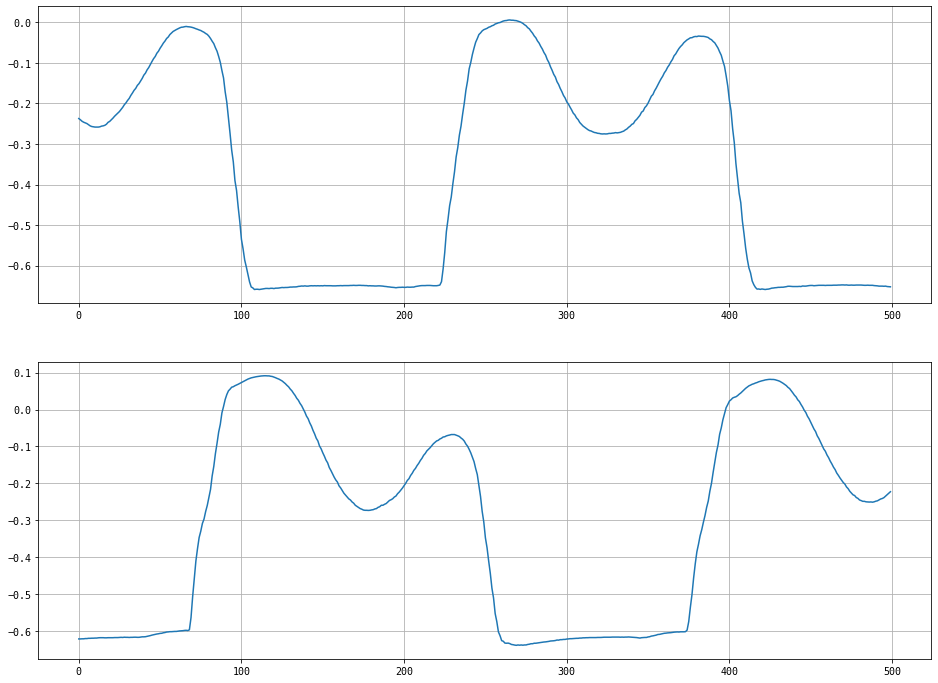

In [50]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

idx = 23
fig, axs = plt.subplots(nrows=2, figsize=(16, 12))
ax = axs[0]
ax.plot(gait_data[idx, 10000:10500, 0])
ax.grid();
ax = axs[1]
ax.plot(gait_data[idx, 10000:10500, 1])
ax.grid(); plt.show(); plt.close();

In [78]:
import numpy as np
from scipy.spatial import distance_matrix
from tqdm import tqdm

def get_weights(pts, exp=1):
    n_pts = len(pts)
    A = np.exp(-distance_matrix(pts, pts))
    b = np.ones(n_pts)
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w.reshape(-1, 1)

def signals_to_curves(signals, dim=5, stride=2):
    # last dimension = channels
    if isinstance(signals, np.ndarray):
        size = signals.shape[-2]
        result = np.concatenate([signals[..., i*stride:size-(dim-i-1)*stride, :] for i in range(dim)], axis=-1)
        return result
    elif isinstance(signals, list):
        return [signals_to_curves(signal, dim, stride) for signal in signals]
    else:
        raise ValueError

def weights_from_pclouds(pclouds, exp=0):
    if exp == 0:
        return [np.ones((pcloud.shape[0], 1)) / pcloud.shape[0] 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]
    else:
        return [get_weights(pcloud, exp) 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]
    
def gaussian_filter(x, mu, sig):
    return np.sum((np.exp(-((x-mu)/sig)**2)), axis=-2)

def linear_filter(x, a):
    return np.sum(x * a, axis=-2)

def trignometric_filter(x, a):
    return np.sin(np.sum(x * a, axis=-2))

def angular_filter(x, mu, a, b):
    angle = np.arctan2(np.sum((x-mu) * a, axis=-2), np.sum((x-mu) * b, axis=-2))
    return np.sin(angle) * np.linalg.norm(x-mu, axis=-2)

def embedding_pclouds(pclouds, weights):
    rng = np.random.default_rng(42)
    
    dim = pclouds[0].shape[-1]

    n_filters = 20
    mu = -2+4*rng.random((n_filters, dim))
    sig = 0.2+2*rng.random((n_filters, dim))

    n_filters = 5
    a = -1+2*rng.random((n_filters, dim))

    n_filters = 20
    b = -1+2*rng.random((n_filters, dim))

    n_filters = 20
    c = -1+2*rng.random((n_filters, dim))
    d = -1+2*rng.random((n_filters, dim))
    nu = -2+4*rng.random((n_filters, dim))
    if isinstance(pclouds, np.ndarray):
        weights = np.array(weights)
        pclouds = np.expand_dims(pclouds, -1)
        f1 = gaussian_filter(pclouds, mu.T, sig.T)
        f2 = linear_filter(pclouds, a.T)
        f3 = trignometric_filter(pclouds, b.T)
        f4 = angular_filter(pclouds, nu.T, c.T, d.T)
        return np.sum(weights * np.concatenate([f1, f2, f3, f4], axis=-1), axis=-2)
    else:
        return [embedding_pclouds(pcloud, weight) 
                for pcloud, weight in tqdm(zip(pclouds, weights), total=len(pclouds), desc='embedding', miniters=100)]


weight computation:   0%|                                                                    | 0/18935 [00:17<?, ?it/s]

In [159]:
np.where(gait_labels_cut == 3)

(array([ 8657,  8658,  8659, ..., 11329, 11330, 11331], dtype=int64),)

In [132]:
rng = np.random.default_rng(42)
test_mask = np.full_like(gait_labels, False, dtype='bool')
for i in range(4):
    for idx in rng.choice(np.where(gait_labels == i)[0], np.sum(gait_labels == i) // 5):
        test_mask[idx] = True
        
gait_data_cut = gait_data.reshape(-1, 500, 2)
gait_labels_cut = np.tile(gait_labels.reshape(-1, 1), (1, 180)).ravel()
test_mask_cut = np.tile(test_mask.reshape(-1, 1), (1, 180)).ravel()

mask_notna = ~np.isnan(gait_data_cut).any(axis=(1,2))
gait_data_cut, gait_labels_cut = gait_data_cut[mask_notna], gait_labels_cut[mask_notna]
test_mask_cut = test_mask_cut[mask_notna]

In [149]:
pclouds = signals_to_curves(gait_data_cut, 3, 20)
weights = weights_from_pclouds(pclouds, 1.)
weights_unif = weights_from_pclouds(pclouds, 0)
embedded = embedding_pclouds(pclouds, weights)
embedded_unif = embedding_pclouds(pclouds, weights_unif)

weight computation: 100%|████████████████████████████████████████████████████| 11332/11332 [00:00<00:00, 252372.69it/s]


In [202]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X = embedded[:, ::1]
X_train, y_train = X[~test_mask_cut], gait_labels_cut[~test_mask_cut]
X_test, y_test = X[test_mask_cut], gait_labels_cut[test_mask_cut]

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9222    0.9248    0.9235       359
           1     0.6286    0.6030    0.6155       539
           2     0.4249    0.5379    0.4748       647
           3     0.1183    0.0852    0.0990       540

    accuracy                         0.5041      2085
   macro avg     0.5235    0.5377    0.5282      2085
weighted avg     0.4838    0.5041    0.4911      2085



In [207]:
from lightgbm import LGBMClassifier
X = embedded[:, ::8]
X_train, y_train = X[~test_mask_cut], gait_labels_cut[~test_mask_cut]
X_test, y_test = X[test_mask_cut], gait_labels_cut[test_mask_cut]

model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6099    0.5487    0.5777       359
           1     0.1946    0.1874    0.1909       539
           2     0.5209    0.7527    0.6157       647
           3     0.3279    0.1870    0.2382       540

    accuracy                         0.4249      2085
   macro avg     0.4133    0.4190    0.4056      2085
weighted avg     0.4019    0.4249    0.4016      2085



In [347]:
import tensorflow as tf
from tensorflow import keras

class MyModel(keras.Model):
    def __init__(self, dim, n_filters=20):
        super(MyModel, self).__init__()
        
        self.means = tf.Variable(
            initial_value=keras.initializers.HeNormal()(shape=(n_filters, dim)),
            trainable=True
        )
        self.pre_stds = tf.Variable(
            initial_value=keras.initializers.HeNormal()(shape=(n_filters, dim)),
            trainable=True
        )
        self.amps = tf.Variable(
            initial_value=keras.initializers.HeNormal()(shape=(n_filters, )),
            trainable=True
        )
        self.fns = [
            keras.layers.BatchNormalization(),
            keras.layers.Dense(
                units=10,
                activation='elu'
            ),
            keras.layers.Dense(
                units=4,
                activation='softmax'
            )
        ]
        
    def call(self, inputs):
        pclouds, weights = inputs
        pclouds = tf.expand_dims(pclouds, -1)
        weights = tf.expand_dims(tf.squeeze(weights, axis=-1), -1)
        stds = (self.pre_stds + tf.math.sqrt(tf.math.square(self.pre_stds) + 1)) / 2
        pclouds_norm = (pclouds - tf.transpose(self.means)) / tf.transpose(stds)
        spikes = self.amps * tf.math.exp(-tf.math.reduce_sum(tf.math.square(pclouds_norm), axis=2))
        outputs = tf.math.reduce_sum(weights*spikes, axis=1, name='summed_up')
        for fn in self.fns:
            outputs = fn(outputs)
        return outputs

# X1 = tf.ragged.constant(pclouds, ragged_rank=1, inner_shape=(6, ))
# X2 = tf.ragged.constant(weights, ragged_rank=1, inner_shape=(1, ))
# X_train = [tf.ragged.boolean_mask(X1, ~test_mask_cut), tf.ragged.boolean_mask(X2, ~test_mask_cut)]
# X_test = [tf.ragged.boolean_mask(X1, test_mask_cut), tf.ragged.boolean_mask(X2, test_mask_cut)]
# y_train, y_test = gait_labels_cut[~test_mask_cut], gait_labels_cut[test_mask_cut]
X_train = [np.stack(pclouds)[~test_mask_cut], np.stack(weights)[~test_mask_cut]]
X_test = [np.stack(pclouds)[test_mask_cut], np.stack(weights)[test_mask_cut]]

In [348]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = MyModel(dim=6, n_filters=10)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(1e-1),
    metrics=['accuracy']
)
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=1 << 10,
)
model.evaluate(X_test, y_test)

Epoch 1/20
10/10 [==============================] - 5s 212ms/step - loss: 1.2088 - accuracy: 0.4507
Epoch 2/20
10/10 [==============================] - 2s 209ms/step - loss: 0.9946 - accuracy: 0.6011
Epoch 3/20
10/10 [==============================] - 2s 210ms/step - loss: 0.8871 - accuracy: 0.6477
Epoch 4/20
10/10 [==============================] - 2s 211ms/step - loss: 0.8231 - accuracy: 0.6575
Epoch 5/20
10/10 [==============================] - 2s 209ms/step - loss: 0.7782 - accuracy: 0.6646
Epoch 6/20
10/10 [==============================] - 2s 211ms/step - loss: 0.7512 - accuracy: 0.6796
Epoch 7/20
10/10 [==============================] - 2s 213ms/step - loss: 0.7325 - accuracy: 0.6741
Epoch 8/20
10/10 [==============================] - 2s 212ms/step - loss: 0.6851 - accuracy: 0.7114
Epoch 9/20
10/10 [==============================] - 2s 212ms/step - loss: 0.6996 - accuracy: 0.6924
Epoch 10/20
10/10 [==============================] - 2s 214ms/step - loss: 0.7028 - accuracy: 0.6991

[2.509505271911621, 0.3870503604412079]

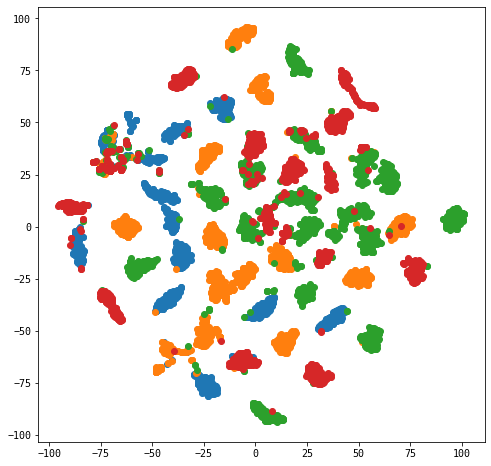

In [199]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(*X_tsne[y_train==i].T)
plt.show(); plt.close();

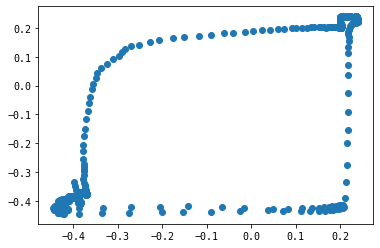

In [174]:
idx = 1000
plt.scatter(gait_data_cut[idx, 20:, 0], gait_data_cut[idx, :-20, 0])

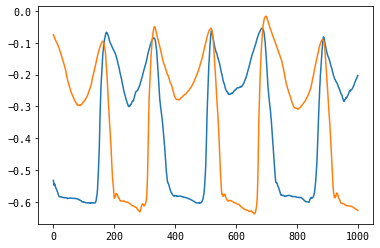

In [176]:
plt.plot(gait_data[0, 10000:11000])

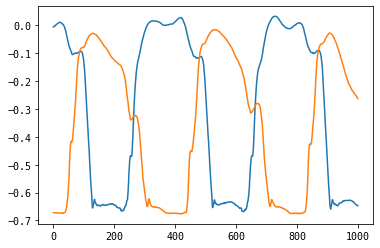

In [177]:
plt.plot(gait_data[3, 10000:11000])

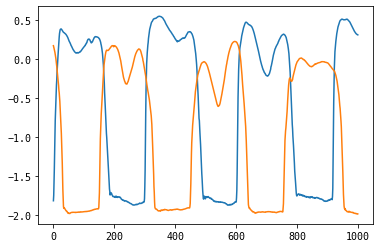

In [196]:
plt.plot(gait_data[45, 10000:11000])